In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class NNAdapter(nn.Module):
    def __init__(self, embedding_model=None, embedding_size=None, output_size=None,
                 hidden_sizes=[512], query_only=False, separate_embeddings=False, device=None):
        """
        When precomputed embeddings are used, you can set `embedding_model=None` and pass embeddings
        directly (the forward method checks the type). The parameters `query_only` and `separate_embeddings`
        work as before.
        """
        super().__init__()
        self.device = device
        self.query_only = query_only
        self.separate_embeddings = separate_embeddings
        if not query_only and embedding_model is None:
            raise ValueError("If not query_only, you must pass an embedding_model")
        self.embed = embedding_model  # might be None when using precomputed embeddings
        
        def gen_adapter():
            layers = []
            prev_size = embedding_size
            for size in hidden_sizes:
                layers.append(nn.Linear(prev_size, size, device=self.device))
                layers.append(nn.ReLU())
                prev_size = size
            layers.append(nn.Linear(prev_size, output_size or embedding_size, device=self.device))
            return nn.Sequential(*layers)
        
        if self.separate_embeddings:
            self.query_adapter = gen_adapter()
            self.doc_adapter = gen_adapter()
        else:
            self.model = gen_adapter()
    
    def forward(self, x, is_query=True):
        """
        If x is already a tensor (precomputed embedding) then use it directly;
        otherwise assume x is raw text and use the frozen embedder.
        """
        if isinstance(x, torch.Tensor):
            x_emb = x
        else:
            x_emb = self.embed.encode(x, convert_to_tensor=True)
            
        if self.separate_embeddings:
            if is_query:
                return self.query_adapter(x_emb)
            else:
                return self.doc_adapter(x_emb)
        else:
            return self.model(x_emb)
    
    def _train_triplet(self, train_data, val_data, optimizer, num_epochs=10, log_losses=True, margin=1.0):
        loss_fn = nn.TripletMarginLoss(margin=margin, reduction='sum')
        losses = []
        for epoch in range(num_epochs):
            total_loss = 0
            for query_emb, pos_emb, neg_emb in train_data:
                optimizer.zero_grad()
                # Only transform the query embedding; pos/neg embeddings remain fixed.
                adapted_query = self(query_emb, is_query=True)
                loss = loss_fn(adapted_query, pos_emb, neg_emb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_data)
            losses.append(avg_loss)
            if log_losses:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
            if epoch%10 == 0:
                self.eval()
                with torch.no_grad():
                    for query_emb, pos_emb, neg_emb in val_data:
                        adapted_query = self(query_emb, is_query=True)
                        val_loss = loss_fn(adapted_query, pos_emb, neg_emb)
                        val_loss += loss.item()
                    val_loss /= len(val_data)
                    print(f"Validation Loss: {val_loss:.4f}")
                self.train()
        return losses
    
    def fit(self,
            triplet_dataset,
            val_dataset=None,
            num_epochs=10,
            margin=1.0,
            batch_size=32,
            lr=3e-3,
            model_save_path: str = None):
        train_data = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)
        val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        losses = self._train_triplet(train_data, val_data, optimizer, num_epochs, margin=margin)
        
        if model_save_path:
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            # In query_only mode we only save the adapter parameters:
            torch.save(self.state_dict(), model_save_path)
        return losses

    def load(self, model_save_path):
        checkpoint = torch.load(model_save_path)
        self.load_state_dict(checkpoint)




In [3]:
import random
import torch
from torch.utils.data import Dataset

class PrecomputedTripletDataset(Dataset):
    def __init__(self, df, query_embeddings, summary_embeddings, device='cuda'):
        """
        df: a pandas DataFrame containing at least a 'cluster_id' column.
        query_embeddings and summary_embeddings should be either a list or numpy array of embeddings
        (or even torch tensors) in the same order as the DataFrame rows.
        """
        self.df = df.reset_index(drop=True)
        self.device = device
        self.query_embeddings = query_embeddings  # e.g., a numpy array or list of vectors
        self.summary_embeddings = summary_embeddings
        self.all_indices = list(range(len(self.df)))
        
        # Build a mapping from cluster id to list of indices (for negative sampling)
        self.cluster_to_indices = {}
        for idx, cluster in enumerate(self.df['cluster_id']):
            self.cluster_to_indices.setdefault(cluster, []).append(idx)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the query and positive summary embedding for this index
        query_emb = self.query_embeddings[idx]
        current_cluster = self.df.loc[idx, 'cluster_id']
        
        # Get all indices whose cluster_id is different
        pos_candidates = [i for i in self.all_indices if self.df.loc[i, 'cluster_id'] == current_cluster]
        neg_candidates = [i for i in self.all_indices if self.df.loc[i, 'cluster_id'] != current_cluster]
        if not neg_candidates:
            raise ValueError("No negative sample candidates found; check your cluster assignments.")
        neg_idx = random.choice(neg_candidates)
        neg_emb = self.summary_embeddings[neg_idx]

        pos_idx = random.choice(pos_candidates)
        pos_emb = self.summary_embeddings[pos_idx]

        
        # Convert to torch.float tensors (if they aren’t already)
        query_tensor = torch.tensor(query_emb, dtype=torch.float).to(self.device)
        pos_tensor = torch.tensor(pos_emb, dtype=torch.float).to(self.device)
        neg_tensor = torch.tensor(neg_emb, dtype=torch.float).to(self.device)
        return query_tensor, pos_tensor, neg_tensor

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Suppose your CSV file has columns: cluster_id, title, summary, title_id, summary_length, query
df = pd.read_csv("movie_remakes_with_queries.csv")

# Split into train and test sets (for example)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Here, assume you have a model that already precomputed the embeddings.
# In your example you used BGEM3FlagModel.
from FlagEmbedding import BGEM3FlagModel
model = BGEM3FlagModel(model_name_or_path="BAAI/bge-m3")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute precomputed embeddings (if not already stored). For example:
train_query_embeddings = model.encode(train_df["query"].tolist(), batch_size=64)["dense_vecs"]
train_summary_embeddings = model.encode(train_df["summary"].tolist(), batch_size=64)["dense_vecs"]

test_query_embeddings = model.encode(test_df["query"].tolist(), batch_size=64)["dense_vecs"]
test_summary_embeddings = model.encode(test_df["summary"].tolist(), batch_size=64)["dense_vecs"]

# Create the triplet dataset.
train_triplet_dataset = PrecomputedTripletDataset(train_df, train_summary_embeddings, train_summary_embeddings, device=device)
test_triplet_dataset = PrecomputedTripletDataset(test_df, test_summary_embeddings, test_summary_embeddings, device=device)

# Define the adapter: since you are only adapting the query embeddings, set query_only=True.
# (Pass embedding_size based on your precomputed embedding dimensionality.)
embedding_size = train_query_embeddings.shape[1]  # for example
adapter = NNAdapter(embedding_model=None,  # not needed when using precomputed embeddings
                    embedding_size=embedding_size,
                    hidden_sizes=[512],
                    query_only=True,
                    device=device)

# Train the adapter with triplet loss.
num_epochs = 100
triplet_margin = 1
batch_size = 128
lr = 3e-4
model_save_path = "saved_adapters/query_adapter.pt"
if not os.path.exists(model_save_path):
    losses = adapter.fit(train_triplet_dataset,
                        val_dataset=test_triplet_dataset,
                        num_epochs=num_epochs,
                        margin=triplet_margin,
                        batch_size=batch_size,
                        lr=lr,
                        model_save_path=model_save_path)
else:
    adapter.load(model_save_path)   
    losses = adapter.fit(train_triplet_dataset,
                        val_dataset=test_triplet_dataset,
                        num_epochs=num_epochs,
                        margin=triplet_margin,
                        batch_size=batch_size,
                        lr=lr,
                        model_save_path=model_save_path)


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\FlagEmbedding\BGE_M3\modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_state_dict = torch.load(o

Epoch 1/100, Loss: 37.8901
Validation Loss: 19.3201
Epoch 2/100, Loss: 37.6178
Epoch 3/100, Loss: 37.2954
Epoch 4/100, Loss: 36.9679
Epoch 5/100, Loss: 36.7633
Epoch 6/100, Loss: 37.6868


KeyboardInterrupt: 

Inference Embeddings: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


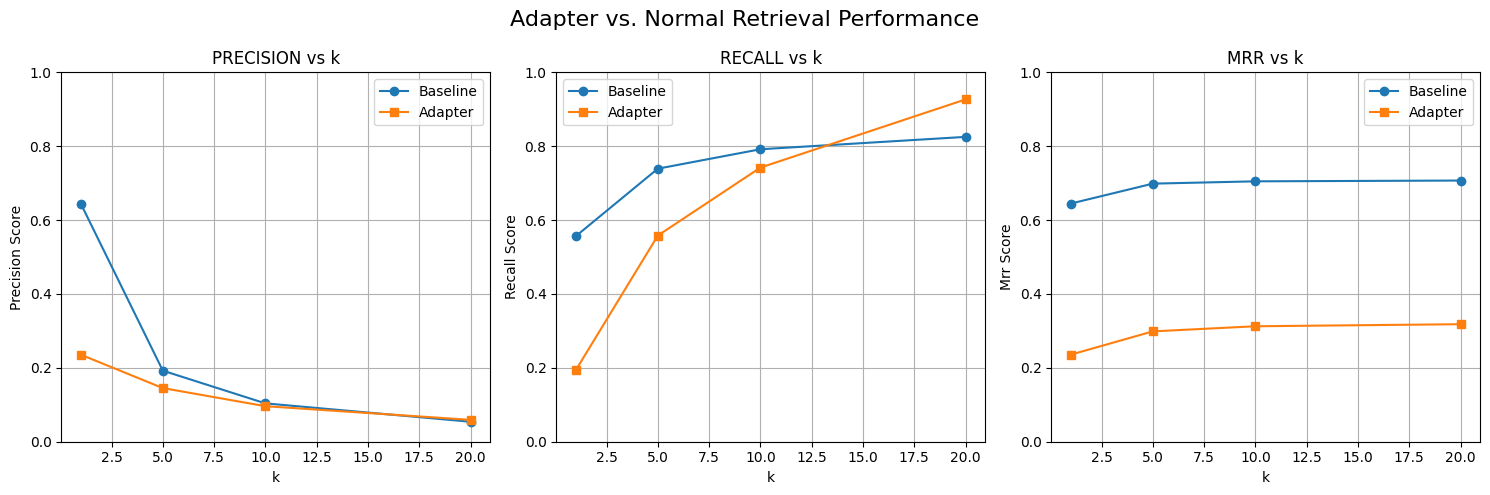

In [12]:
from matplotlib import pyplot as plt
def evaluate_topk_retrieval(cluster_ids, embeddings, query_embeddings = None, k=10, metric='cosine'):
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
    import builtins 

    n_samples = len(embeddings)
    if metric == 'cosine':
        metric_fn = cosine_similarity
    elif metric == 'euclidean':
        metric_fn = euclidean_distances
    else:
        raise ValueError("Unknown metric!")
    
    if query_embeddings is not None:
        sim_matrix = metric_fn(query_embeddings, embeddings)
    else:
        sim_matrix = metric_fn(embeddings, embeddings)
        np.fill_diagonal(sim_matrix, -np.inf)
    
 
    topk_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
    
    precisions = []
    recalls = []
    mrr = []  
    
    for i in range(n_samples):
        query_cluster = cluster_ids[i]
        retrieved_clusters = [cluster_ids[idx] for idx in topk_indices[i]]
        
       
        relevant_count = builtins.sum(1 for cid in cluster_ids if cid == query_cluster) - 1
        

        relevant_retrieved = builtins.sum(1 for c in retrieved_clusters if c == query_cluster)
        precision = relevant_retrieved / k
        recall = relevant_retrieved / relevant_count if relevant_count > 0 else 0
        
        rr = 0
        for rank, c in enumerate(retrieved_clusters, start=1):
            if c == query_cluster:
                rr = 1 / rank
                break
            
        precisions.append(precision)
        recalls.append(recall)
        mrr.append(rr)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        'mrr': np.mean(mrr)
    }

testing_df = df
cluster_ids = testing_df['cluster_id'].tolist()

k_values = [1, 5, 10, 20]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Adapter vs. Normal Retrieval Performance', fontsize=16)
axs = axs.flatten()
metrics = ['precision', 'recall', 'mrr']

test_query_embeddings = model.encode(testing_df["query"].tolist(), batch_size=64)["dense_vecs"]
test_summary_embeddings = model.encode(testing_df["summary"].tolist(), batch_size=64)["dense_vecs"]
adapter.eval()
with torch.no_grad():
    # Convert precomputed embeddings to tensors (if they aren't already)
    tq = torch.tensor(test_query_embeddings, dtype=torch.float).to(device)
    ts = torch.tensor(test_summary_embeddings, dtype=torch.float).to(device)
    
    # Adapt the query embeddings (only the queries get passed through the adapter)
    adapted_queries = adapter(tq, is_query=True)
    # Optionally, L2 normalize if you plan to use dot product as cosine similarity:
    adapted_queries = F.normalize(adapted_queries, p=2, dim=1)
    normalized_summaries = F.normalize(ts, p=2, dim=1)
        

results_by_k_query = {k: evaluate_topk_retrieval(cluster_ids, test_summary_embeddings, k=k) for k in k_values}
results_by_k_fitted = {k: evaluate_topk_retrieval(cluster_ids, normalized_summaries.cpu().numpy(), query_embeddings=adapted_queries.cpu().numpy(), k=k) for k in k_values}


for i, metric in enumerate(metrics):

    ax1 = axs[i]
    if metric == 'mrr':
        values_query = [results_by_k_query[k]['mrr'] for k in k_values]
        values_no_query = [results_by_k_fitted[k]['mrr'] for k in k_values]
    else:
        values_query = [results_by_k_query[k][f'{metric}@{k}'] for k in k_values]
        values_no_query = [results_by_k_fitted[k][f'{metric}@{k}'] for k in k_values]
    
    ax1.plot(k_values, values_query, marker='o', label='Baseline')
    ax1.plot(k_values, values_no_query, marker='s', label='Adapter')
    ax1.set_xlabel('k')
    ax1.set_ylabel(f'{metric.capitalize()} Score')
    ax1.set_title(f'{metric.upper()} vs k')
    ax1.set_ylim(0, 1)
    ax1.grid(True)
    ax1.legend() 
plt.tight_layout()
plt.show()

In [79]:
test_df.groupby('cluster_id').size().describe()

count    142.000000
mean       1.225352
std        0.451858
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
dtype: float64